<a href="https://colab.research.google.com/github/agrawalabr/deeplearning/blob/main/Vison%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers(VIT) | Transformers in Computer Vision

Transformer architectures, originally designed for Natural Language Processing (NLP), have revolutionized the field of deep learning, forming the backbone of state-of-the-art models across various NLP applications. More recently, these architectures have been successfully adapted to computer vision tasks, leading to a new paradigm in image processing.

The [Vision Transformer (ViT)](https://arxiv.org/pdf/2010.11929), gained large attention in 2021, demonstrates how standard transformer architectures can achieve competitive performance on image classification tasks. The core idea is to split an image into smaller patches, treat each patch as a token, and process them using a sequence of self-attention-based transformer blocks. This approach eliminates the need for traditional convolutional neural networks (CNNs), offering a more flexible and scalable framework for vision tasks.

However, working with ViTs presents a few challenges:
- Computational Complexity: ViTs require significantly more computational resources compared to CNNs due to their high number of parameters. Training from scratch demands large-scale datasets and extensive GPU/TPU resources.
- Interpretability: Unlike CNNs, which leverage spatial hierarchies, transformers rely on global attention mechanisms, making them even more difficult to interpret.
-	Pretraining Dependency: In most practical scenarios, ViTs are pre-trained on massive datasets (e.g., ImageNet-21k, JFT-300M) before being fine-tuned on specific downstream tasks. Training from scratch is feasible but often impractical for smaller datasets.

Despite these challenges, ViTs have shown impressive results in image classification, object detection, and segmentation, signaling a shift in deep learning methodologies for vision tasks. In this notebook, we will explore how to build a Vision Transformer from scratch, gaining insights into its structure, training requirements, and performance characteristics.

- Name: Abhishek Agrawal
- NetId: aa9360

In [1]:
!pip install einops
!pip install torchinfo

In [2]:
import torch
from torch import nn
from torch import nn, einsum
import torch.nn.functional as F
from torch import optim
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
import torchvision
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [3]:
torch.manual_seed(42)
DOWNLOAD_PATH = './data'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000
MEAN = 0.2859
STD = 0.3530

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainingdata = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testdata = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.6MB/s]


In [5]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

In [6]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
            PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
            PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width), nn.Linear(patch_dim, dim),)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, num_classes))

    def forward(self, img):

        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)

        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [8]:
from torch.cuda.amp import autocast, GradScaler
from copy import deepcopy
scaler = GradScaler()

heads_list = [2,3,4]
depth_list = [4,5,6,7,8]
num_epochs = 5
best_test_acc = 0.0
best_model_state = None
best_config = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for depth in depth_list:
    for heads in heads_list:
        print(f"\n Testing config: heads={heads}, depth={depth}")

        model = ViT(image_size=28, patch_size=4, num_classes=10, channels=1, dim=64, depth=depth, heads=heads, mlp_dim=128)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        model.to(device)

        for epoch in range(num_epochs):
            model.train()
            total_train = 0
            correct_train = 0
            running_loss = 0.0

            for images, labels in tqdm(trainDataLoader, desc=f"Epoch {epoch+1}/{num_epochs} - Train", leave=False):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

            train_acc = correct_train / total_train
            train_loss = running_loss / len(trainDataLoader)

            model.eval()
            total_test = 0
            correct_test = 0
            test_loss = 0.0

            with torch.no_grad():
                for images, labels in testDataLoader:
                    images, labels = images.to(device), labels.to(device)
                    with torch.cuda.amp.autocast():
                        outputs = model(images)
                        loss = loss_fn(outputs, labels)
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct_test += (predicted == labels).sum().item()
                    total_test += labels.size(0)

            test_acc = correct_test / total_test
            test_loss /= len(testDataLoader)

            print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

        # Store best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = deepcopy(model.state_dict())
            best_config = {'heads': heads, 'depth': depth}

print("\n✅ Best model config:")
print(f" - Heads: {best_config['heads']}")
print(f" - Depth: {best_config['depth']}")
print(f" - Test Accuracy: {best_test_acc:.4f}")
torch.save(best_model_state, "best_vit_model.pth")

<ipython-input-8-bd5ab51edd09>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



 Testing config: heads=2, depth=4


Epoch 1/5 - Train:   0%|          | 0/938 [00:00<?, ?it/s]<ipython-input-8-bd5ab51edd09>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-8-bd5ab51edd09>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train Loss: 0.6265, Acc: 0.7752 | Test Loss: 0.4582, Acc: 0.8364


Epoch 2 | Train Loss: 0.4199, Acc: 0.8463 | Test Loss: 0.4180, Acc: 0.8429


Epoch 3 | Train Loss: 0.3788, Acc: 0.8614 | Test Loss: 0.3957, Acc: 0.8534


Epoch 4 | Train Loss: 0.3502, Acc: 0.8723 | Test Loss: 0.3757, Acc: 0.8607


Epoch 5 | Train Loss: 0.3334, Acc: 0.8777 | Test Loss: 0.3749, Acc: 0.8618

 Testing config: heads=3, depth=4


Epoch 1 | Train Loss: 0.5969, Acc: 0.7830 | Test Loss: 0.4742, Acc: 0.8223


Epoch 2 | Train Loss: 0.4079, Acc: 0.8508 | Test Loss: 0.4294, Acc: 0.8456


Epoch 3 | Train Loss: 0.3671, Acc: 0.8655 | Test Loss: 0.4015, Acc: 0.8523


Epoch 4 | Train Loss: 0.3472, Acc: 0.8730 | Test Loss: 0.3685, Acc: 0.8675


Epoch 5 | Train Loss: 0.3249, Acc: 0.8801 | Test Loss: 0.3529, Acc: 0.8705

 Testing config: heads=4, depth=4


Epoch 1 | Train Loss: 0.5959, Acc: 0.7855 | Test Loss: 0.4649, Acc: 0.8346


Epoch 2 | Train Loss: 0.4043, Acc: 0.8528 | Test Loss: 0.4299, Acc: 0.8471


Epoch 3 | Train Loss: 0.3654, Acc: 0.8668 | Test Loss: 0.4354, Acc: 0.8412


Epoch 4 | Train Loss: 0.3389, Acc: 0.8752 | Test Loss: 0.3775, Acc: 0.8636


Epoch 5 | Train Loss: 0.3167, Acc: 0.8824 | Test Loss: 0.3657, Acc: 0.8655

 Testing config: heads=2, depth=5


Epoch 1 | Train Loss: 0.6070, Acc: 0.7810 | Test Loss: 0.4552, Acc: 0.8351


Epoch 2 | Train Loss: 0.4181, Acc: 0.8476 | Test Loss: 0.4152, Acc: 0.8507


Epoch 3 | Train Loss: 0.3711, Acc: 0.8629 | Test Loss: 0.4238, Acc: 0.8427


Epoch 4 | Train Loss: 0.3480, Acc: 0.8715 | Test Loss: 0.3926, Acc: 0.8586


Epoch 5 | Train Loss: 0.3258, Acc: 0.8797 | Test Loss: 0.3602, Acc: 0.8678

 Testing config: heads=3, depth=5


Epoch 1 | Train Loss: 0.5994, Acc: 0.7829 | Test Loss: 0.4496, Acc: 0.8322


Epoch 2 | Train Loss: 0.4060, Acc: 0.8522 | Test Loss: 0.3967, Acc: 0.8521


Epoch 3 | Train Loss: 0.3659, Acc: 0.8651 | Test Loss: 0.3653, Acc: 0.8663


Epoch 4 | Train Loss: 0.3364, Acc: 0.8777 | Test Loss: 0.3889, Acc: 0.8600


Epoch 5 | Train Loss: 0.3183, Acc: 0.8840 | Test Loss: 0.4130, Acc: 0.8481

 Testing config: heads=4, depth=5


Epoch 1 | Train Loss: 0.5742, Acc: 0.7909 | Test Loss: 0.4391, Acc: 0.8445


Epoch 2 | Train Loss: 0.3928, Acc: 0.8558 | Test Loss: 0.4075, Acc: 0.8505


Epoch 3 | Train Loss: 0.3538, Acc: 0.8693 | Test Loss: 0.3924, Acc: 0.8552


Epoch 4 | Train Loss: 0.3273, Acc: 0.8800 | Test Loss: 0.3772, Acc: 0.8623


Epoch 5 | Train Loss: 0.3105, Acc: 0.8865 | Test Loss: 0.3494, Acc: 0.8715

 Testing config: heads=2, depth=6


Epoch 1 | Train Loss: 0.6130, Acc: 0.7784 | Test Loss: 0.4759, Acc: 0.8274


Epoch 2 | Train Loss: 0.4084, Acc: 0.8508 | Test Loss: 0.4306, Acc: 0.8389


Epoch 3 | Train Loss: 0.3688, Acc: 0.8644 | Test Loss: 0.3919, Acc: 0.8574


Epoch 4 | Train Loss: 0.3442, Acc: 0.8719 | Test Loss: 0.3610, Acc: 0.8669


Epoch 5 | Train Loss: 0.3255, Acc: 0.8784 | Test Loss: 0.3661, Acc: 0.8638

 Testing config: heads=3, depth=6


Epoch 1 | Train Loss: 0.5939, Acc: 0.7819 | Test Loss: 0.4633, Acc: 0.8299


Epoch 2 | Train Loss: 0.3954, Acc: 0.8553 | Test Loss: 0.3892, Acc: 0.8554


Epoch 3 | Train Loss: 0.3606, Acc: 0.8682 | Test Loss: 0.3871, Acc: 0.8599


Epoch 4 | Train Loss: 0.3317, Acc: 0.8781 | Test Loss: 0.3822, Acc: 0.8651


Epoch 5 | Train Loss: 0.3159, Acc: 0.8837 | Test Loss: 0.3424, Acc: 0.8751

 Testing config: heads=4, depth=6


Epoch 1 | Train Loss: 0.5900, Acc: 0.7871 | Test Loss: 0.4563, Acc: 0.8275


Epoch 2 | Train Loss: 0.3949, Acc: 0.8563 | Test Loss: 0.4000, Acc: 0.8521


Epoch 3 | Train Loss: 0.3496, Acc: 0.8716 | Test Loss: 0.3684, Acc: 0.8706


Epoch 4 | Train Loss: 0.3259, Acc: 0.8802 | Test Loss: 0.3481, Acc: 0.8727


Epoch 5 | Train Loss: 0.3041, Acc: 0.8872 | Test Loss: 0.3546, Acc: 0.8730

 Testing config: heads=2, depth=7


Epoch 1 | Train Loss: 0.6182, Acc: 0.7765 | Test Loss: 0.4776, Acc: 0.8288


Epoch 2 | Train Loss: 0.4163, Acc: 0.8481 | Test Loss: 0.4135, Acc: 0.8471


Epoch 3 | Train Loss: 0.3729, Acc: 0.8616 | Test Loss: 0.3705, Acc: 0.8634


Epoch 4 | Train Loss: 0.3482, Acc: 0.8700 | Test Loss: 0.3628, Acc: 0.8651


Epoch 5 | Train Loss: 0.3292, Acc: 0.8768 | Test Loss: 0.3659, Acc: 0.8638

 Testing config: heads=3, depth=7


Epoch 1 | Train Loss: 0.5953, Acc: 0.7835 | Test Loss: 0.4436, Acc: 0.8365


Epoch 2 | Train Loss: 0.3933, Acc: 0.8546 | Test Loss: 0.4132, Acc: 0.8494


Epoch 3 | Train Loss: 0.3613, Acc: 0.8674 | Test Loss: 0.3714, Acc: 0.8625


Epoch 4 | Train Loss: 0.3382, Acc: 0.8742 | Test Loss: 0.3630, Acc: 0.8706


Epoch 5 | Train Loss: 0.3151, Acc: 0.8837 | Test Loss: 0.3706, Acc: 0.8691

 Testing config: heads=4, depth=7


Epoch 1 | Train Loss: 0.5781, Acc: 0.7893 | Test Loss: 0.4371, Acc: 0.8405


Epoch 2 | Train Loss: 0.3858, Acc: 0.8570 | Test Loss: 0.4267, Acc: 0.8432


Epoch 3 | Train Loss: 0.3488, Acc: 0.8730 | Test Loss: 0.3599, Acc: 0.8710


Epoch 4 | Train Loss: 0.3247, Acc: 0.8813 | Test Loss: 0.3933, Acc: 0.8571


Epoch 5 | Train Loss: 0.3064, Acc: 0.8872 | Test Loss: 0.3611, Acc: 0.8693

 Testing config: heads=2, depth=8


Epoch 1 | Train Loss: 0.6124, Acc: 0.7786 | Test Loss: 0.4486, Acc: 0.8346


Epoch 2 | Train Loss: 0.3986, Acc: 0.8539 | Test Loss: 0.4399, Acc: 0.8408


Epoch 3 | Train Loss: 0.3599, Acc: 0.8688 | Test Loss: 0.3684, Acc: 0.8653


Epoch 4 | Train Loss: 0.3353, Acc: 0.8756 | Test Loss: 0.3685, Acc: 0.8648


Epoch 5 | Train Loss: 0.3174, Acc: 0.8834 | Test Loss: 0.3563, Acc: 0.8702

 Testing config: heads=3, depth=8


Epoch 1 | Train Loss: 0.5905, Acc: 0.7829 | Test Loss: 0.4420, Acc: 0.8379


Epoch 2 | Train Loss: 0.3932, Acc: 0.8563 | Test Loss: 0.4046, Acc: 0.8505


Epoch 3 | Train Loss: 0.3574, Acc: 0.8683 | Test Loss: 0.3975, Acc: 0.8488


Epoch 4 | Train Loss: 0.3342, Acc: 0.8771 | Test Loss: 0.3541, Acc: 0.8729


Epoch 5 | Train Loss: 0.3177, Acc: 0.8815 | Test Loss: 0.3491, Acc: 0.8736

 Testing config: heads=4, depth=8


Epoch 1 | Train Loss: 0.6166, Acc: 0.7760 | Test Loss: 0.4560, Acc: 0.8300


Epoch 2 | Train Loss: 0.4037, Acc: 0.8528 | Test Loss: 0.4086, Acc: 0.8493


Epoch 3 | Train Loss: 0.3627, Acc: 0.8661 | Test Loss: 0.3945, Acc: 0.8585


Epoch 4 | Train Loss: 0.3408, Acc: 0.8740 | Test Loss: 0.3554, Acc: 0.8654


Epoch 5 | Train Loss: 0.3192, Acc: 0.8809 | Test Loss: 0.3749, Acc: 0.8589

✅ Best model config:
 - Heads: 3
 - Depth: 6
 - Test Accuracy: 0.8751


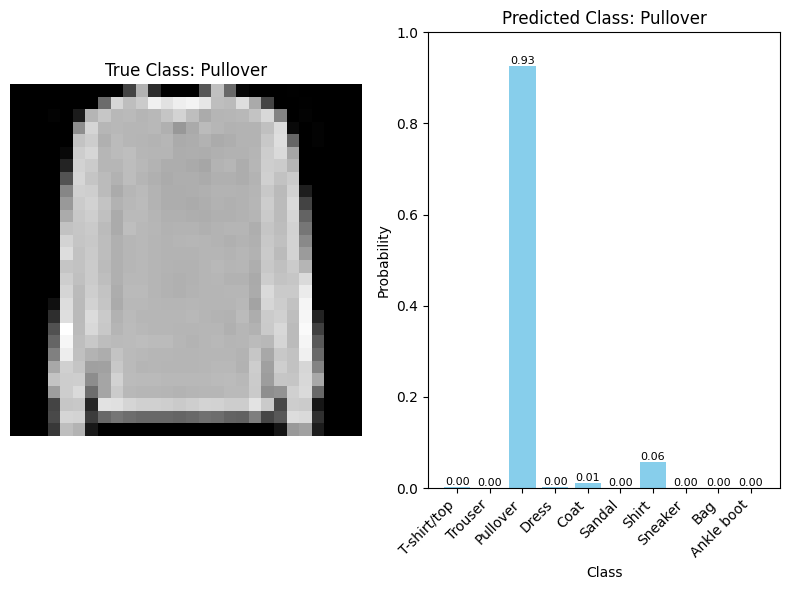

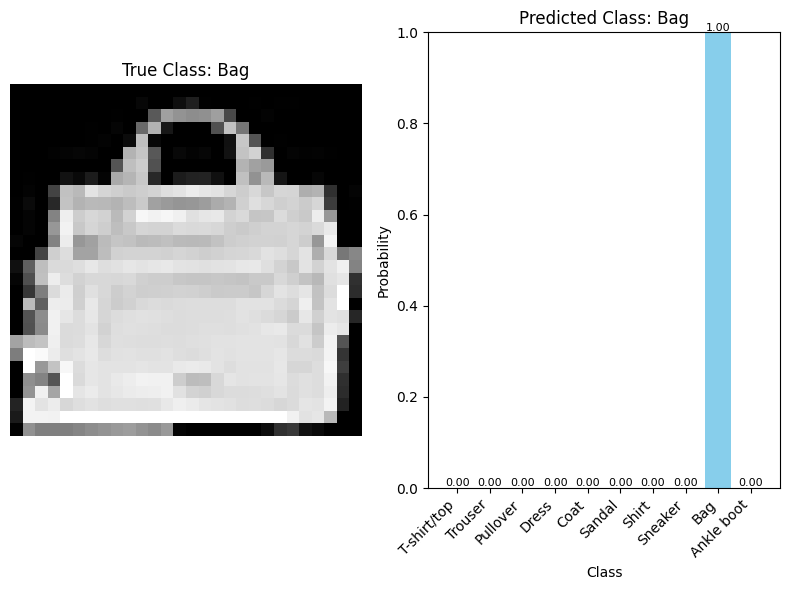

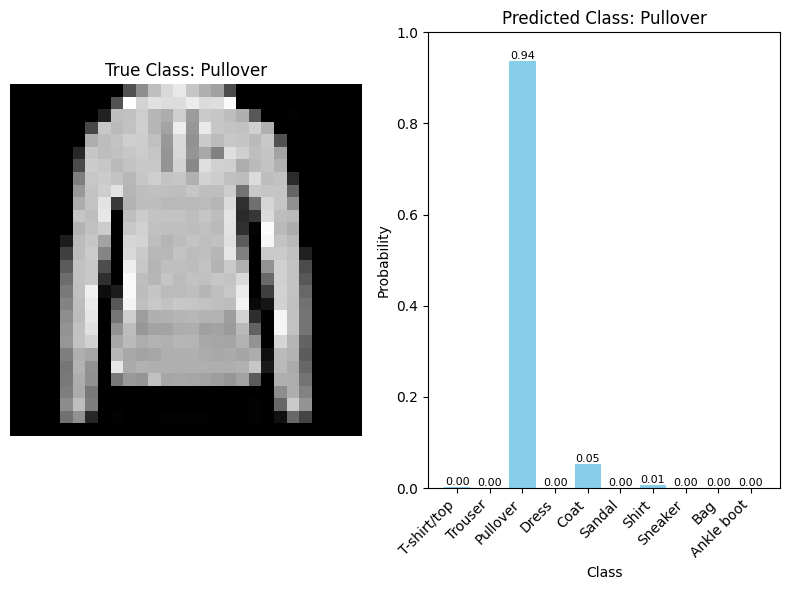

In [12]:
def display_image_with_probabilities(image, probabilities, predicted_class, true_class):
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    plt.figure(figsize=(8, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True Class: {classes[true_class]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    bars = plt.bar(np.arange(len(probabilities)), probabilities, color='skyblue')
    plt.xticks(np.arange(len(probabilities)), classes, rotation=45, ha='right')
    plt.ylabel('Probability')
    plt.xlabel('Class')
    plt.title(f"Predicted Class: {classes[predicted_class]}")
    plt.ylim(0, 1)  # Set y-axis limit to [0, 1]

    for bar, prob in zip(bars, probabilities):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{prob:.2f}', ha='center', va='bottom', color='black', fontsize=8)

    plt.tight_layout()
    plt.show()

restored_model = ViT(image_size=28, patch_size=4, num_classes=10, channels=1, dim=64, depth=6, heads=3, mlp_dim=128)
restored_model.load_state_dict(best_model_state)

restored_model.eval()

sample_indices = np.random.choice(len(testdata), 3, replace=False)
for index in sample_indices:
    image, true_class = testdata[index]
    image_tensor = image.unsqueeze(0).to(next(restored_model.parameters()).device)

    with torch.no_grad():
        predicted_output = restored_model(image_tensor)
        predicted_probabilities = F.softmax(predicted_output, dim=1).squeeze().cpu().numpy()
        predicted_class = torch.argmax(predicted_output, dim=1).item()

    display_image_with_probabilities(image, predicted_probabilities, predicted_class, true_class)